In [1]:
# local import for testing
import sys, os
sys.path.insert(1, '../src/SupplyNetPy/Components/')
import core as scm
import utilities as scm

In [2]:

supplier = {'ID': 'S1', 'name': 'Supplier', 'node_type': 'infinite_supplier'}
manufacturer = {'ID': 'M1', 'name': 'Manufacturer', 'node_type': 'manufacturer',
                'capacity': 300, 'initial_level': 50, 'inventory_holding_cost': 0.5,
                'replenishment_policy': 'sS', 'policy_param': [150], 'product_sell_price': 310}
distributor = {'ID': 'D1', 'name': 'Distributor', 'node_type': 'distributor',
               'capacity': 200, 'initial_level': 100, 'inventory_holding_cost': 1,
               'replenishment_policy': 'sS', 'policy_param': [100], 'product_sell_price': 320}
link_s1m1 = {'ID': 'L1', 'source': 'S1', 'sink': 'M1', 'cost': 5, 'lead_time': lambda: 3}
link_m1d1 = {'ID': 'L2', 'source': 'M1', 'sink': 'D1', 'cost': 5, 'lead_time': lambda: 2}
demand = {'ID': 'demand_D1', 'name': 'Demand at Distributor', 'node_type': 'demand',
          'order_arrival_model': lambda: 1, 'order_quantity_model': lambda: 10, 'demand_node': 'D1'}

scnet = scm.create_sc_net([supplier, manufacturer, distributor], [link_s1m1, link_m1d1], [demand])


In [3]:
scm.global_logger.enable_logging(log_to_file=False)
scnet = scm.simulate_sc_net(scnet, sim_time=100)

INFO sim_trace - 0.0000:demand_D1:Customer0:Demand at Distributor, Order quantity:10, available.
INFO sim_trace - 0.0000:demand_D1:Customer0:Demand at Distributor, Order quantity:10 received. Current inv: 90
INFO sim_trace - 0.9990:D1: Inventory levels:90
INFO sim_trace - 0.9990:D1:Product not available at suppliers. Required quantity:110.
INFO sim_trace - 0.9999:M1: Raw materials' inventory levels:{'RM1': 0}, Product inventory levels:50
INFO sim_trace - 0.9999:M1:Replenishing raw material:Raw Material 1 from supplier:S1, order placed for 750 units.
INFO sim_trace - 0.9999:M1:shipment in transit from supplier:Supplier.
INFO sim_trace - 1.0000:demand_D1:Customer1:Demand at Distributor, Order quantity:10, available.
INFO sim_trace - 1.0000:demand_D1:Customer1:Demand at Distributor, Order quantity:10 received. Current inv: 80
INFO sim_trace - 1.9990:D1: Inventory levels:80
INFO sim_trace - 1.9990:D1:Product not available at suppliers. Required quantity:120.
INFO sim_trace - 1.9999:M1: Raw

In [4]:
scnet = scm.simulate_sc_net(scnet, sim_time=100)

WARNING sim_trace - You have already ran simulation for this network! 
 To create a new network use create_sc_net(), or specify the simulation time grater than 100 to run it further.


In [5]:
import simpy
env = simpy.Environment()

shelf_life = 90

scm.default_raw_material = scm.RawMaterial(ID="RM1", name="Raw Material 1", extraction_quantity=1000, extraction_time=1, mining_cost=0.9, cost=3) # create a default raw material
scm.deafult_product = scm.Product(ID="P1", name="Product 1", manufacturing_cost=50, manufacturing_time=3, sell_price=341, raw_materials=[{"raw_material": scm.default_raw_material, "quantity": 3}], units_per_cycle=100) # create a default product

sup = scm.Supplier(env=env, ID='S1', name='Supplier', node_type="supplier", capacity=3000, initial_level=3000, 
                   inventory_holding_cost=0.1)

man = scm.Manufacturer(env=env, ID='M1', name='Manufacturer', capacity=800, initial_level=800, inventory_holding_cost=0.5,
                       inventory_type="perishable", shelf_life=shelf_life, replenishment_policy="sS", policy_param=[400], 
                       product_sell_price=310)

dis = scm.InventoryNode(env=env, ID='D1', name='Distributor', node_type="warehouse", capacity=500, initial_level=500, 
                        inventory_holding_cost=1, inventory_type="perishable", shelf_life=shelf_life, replenishment_policy="sS",
                        policy_param=[200], product_sell_price=320)

ret = scm.InventoryNode(env=env, ID='R1', name='Retailer', node_type="retailer", capacity=200, initial_level=200,
                        inventory_holding_cost=2, inventory_type="perishable", shelf_life=shelf_life, replenishment_policy="sS",
                        policy_param=[100], product_sell_price=330)

link_s1m1 = scm.Link(env=env, ID='L1', source=sup, sink=man, cost=5, lead_time=lambda: 3)
link_m1d1 = scm.Link(env=env, ID='L2', source=man, sink=dis, cost=5, lead_time=lambda: 2)
link_d1r1 = scm.Link(env=env, ID='L3', source=dis, sink=ret, cost=5, lead_time=lambda: 1)

demand_ret = scm.Demand(env=env, ID='demand_R1', name='Demand at Retailer', order_arrival_model=lambda: 1,
                        order_quantity_model=lambda: 50, demand_node=ret, tolerance = 2)

scm.global_logger.enable_logging(log_to_file=False)
env.run(until=720)

INFO sim_trace - 0.0000:demand_R1:Customer0:Demand at Retailer, Order quantity:50, available.
INFO sim_trace - 0.0000:demand_R1:Customer0:Demand at Retailer, Order quantity:50 received. Current inv: 150
INFO sim_trace - 0.9990:D1: Inventory levels:500
INFO sim_trace - 0.9990:R1: Inventory levels:150
INFO sim_trace - 0.9999:M1: Raw materials' inventory levels:{'RM1': 0}, Product inventory levels:800
INFO sim_trace - 1.0000:S1: Inventory level:3000
INFO sim_trace - 1.0000:demand_R1:Customer1:Demand at Retailer, Order quantity:50, available.
INFO sim_trace - 1.0000:demand_R1:Customer1:Demand at Retailer, Order quantity:50 received. Current inv: 100
INFO sim_trace - 1.9990:D1: Inventory levels:500
INFO sim_trace - 1.9990:R1: Inventory levels:100
INFO sim_trace - 1.9990:R1:Replenishing inventory from supplier:Distributor, order placed for 100 units.
INFO sim_trace - 1.9990:R1:shipment in transit from supplier:Distributor.
INFO sim_trace - 1.9999:M1: Raw materials' inventory levels:{'RM1': 0

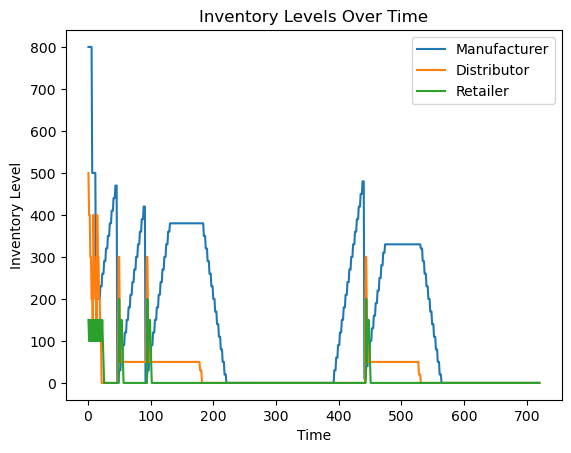

In [6]:
#plot inventory levels
import numpy as np
import matplotlib.pyplot as plt

for node in [man,dis,ret]:
    inv_levels = np.array(node.inventory.instantaneous_levels)
    plt.plot(inv_levels[:,0], inv_levels[:,1], label=node.name)
plt.xlabel('Time')
plt.ylabel('Inventory Level')
plt.title('Inventory Levels Over Time')
plt.legend()
plt.show()